In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
import datetime as dt
from datetime import datetime, timedelta
from sklearn import preprocessing
import os
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy import stats

В сентябре 2023 на АЗС 035 произведена смена ДТ на ДТ Танеко.  
**Задача**: проанализировать как смена сортности повлияла на основные показатели продаж АЗС 035.  
Для анализа сформирована выборка из АЗС по схожему месторасположению:  
- АЗС 035: расположена на Щёлковском шоссе в Москву  
- АЗС 034: расположена зеркально АЗС 035  
- АЗС 207: расположена на Новорязанском шоссе в Москву  
- АЗС 157: расположена на Симферопольском шоссе в Москву  

# Гипотезы  
1. Замена ДТ на ДТ Танеко привело к увеличению продаж ДТ на АЗС 035  
2. Смена сортности позволила больше обслуживать клиентов ФЛ  
3. Выросли продаж НП ФЛ по бензинам  
4. Произошёл рост конверсии  
5. Смена сортности привела к увеличению дохода

# Загрузка данных

In [514]:
# список АЗС для загрузки данных
list_azs = [
    'АЗС 034',
    'АЗС 035',
    'АЗС 207',
    'АЗС 157'
]

In [515]:
# данные 2023 года
path = 'D:/QS/2023/oil/operational/preprocessed_operational/'
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
for x in data:
    month = pd.read_csv(path + x, parse_dates= ['FL_EVBDATE']) \
        .query('type_client == "ФЛ" & AZS_NAME == @list_azs')
    list_df.append(month)
df_2023 = pd.concat(list_df, axis=0, ignore_index=True)

In [516]:
# данные 2022 года
path = 'D:/QS/2022/oil/operational/preprocessed_operational/'
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
for x in data:
    month = pd.read_csv(path + x, parse_dates= ['FL_EVBDATE']) \
        .query('type_client == "ФЛ" & AZS_NAME == @list_azs')
    list_df.append(month)
df_2022 = pd.concat(list_df, axis=0, ignore_index=True)

# Гипотеза 1  
*Замена ДТ на ДТ Танеко привело к увеличению продаж ДТ на АЗС 035*  

In [517]:
df_2023.head(2)

,AZS_NUM,AZS_NAME,FL_EVBDATE,FL_EVBTIME,TIME_KEY,PAY_NAME,FL_VOLUME,FL_MASSA,MASSA_TN,PROD_NAME,KS_WRKPLACE,KS_DOCNUM,KS_EV_NAME,FL_TANK,FL_TRK,FL_HAND,type_client
0,34,АЗС 034,2023-01-29,21:15:02,2023-01-29,Яндекс (Физ. лица),30.00,22.0860,0.022086,Бензин АИ-95,20,0,Продажа,2,3,2,ФЛ
1,34,АЗС 034,2023-01-29,21:45:01,2023-01-29,Яндекс (Физ. лица),21.28,15.5876,0.015588,Бензин АИ-92,20,0,Продажа,3,3,3,ФЛ


In [518]:
list(df_2023.PROD_NAME.unique())

['Бензин АИ-95',
 'Бензин АИ-92',
 'Дизельное топливо',
 'Дизельное топливо (евро)',
 'Бензин АИ-98']

In [519]:
map_product = {
    'Бензин АИ-92': 'бензин',
    'Бензин АИ-95': 'бензин',
    'Дизельное топливо': 'дт',
    'Бензин АИ-98': 'бензин',
    'Дизельное топливо (евро)': 'дт'
}

In [520]:
# добавление вида нефтепродукта в датасет
df_2023['type_product'] = df_2023.PROD_NAME.map(map_product)

In [521]:
# фильтр продаж в 2023 по ДТ
df = df_2023 \
    .query('type_product == "дт"') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'MASSA_TN': 'sum'})

## Оценка выборки АЗС  
*Подбор схожей по продажам дт станции с АЗС 035 до 01.09*

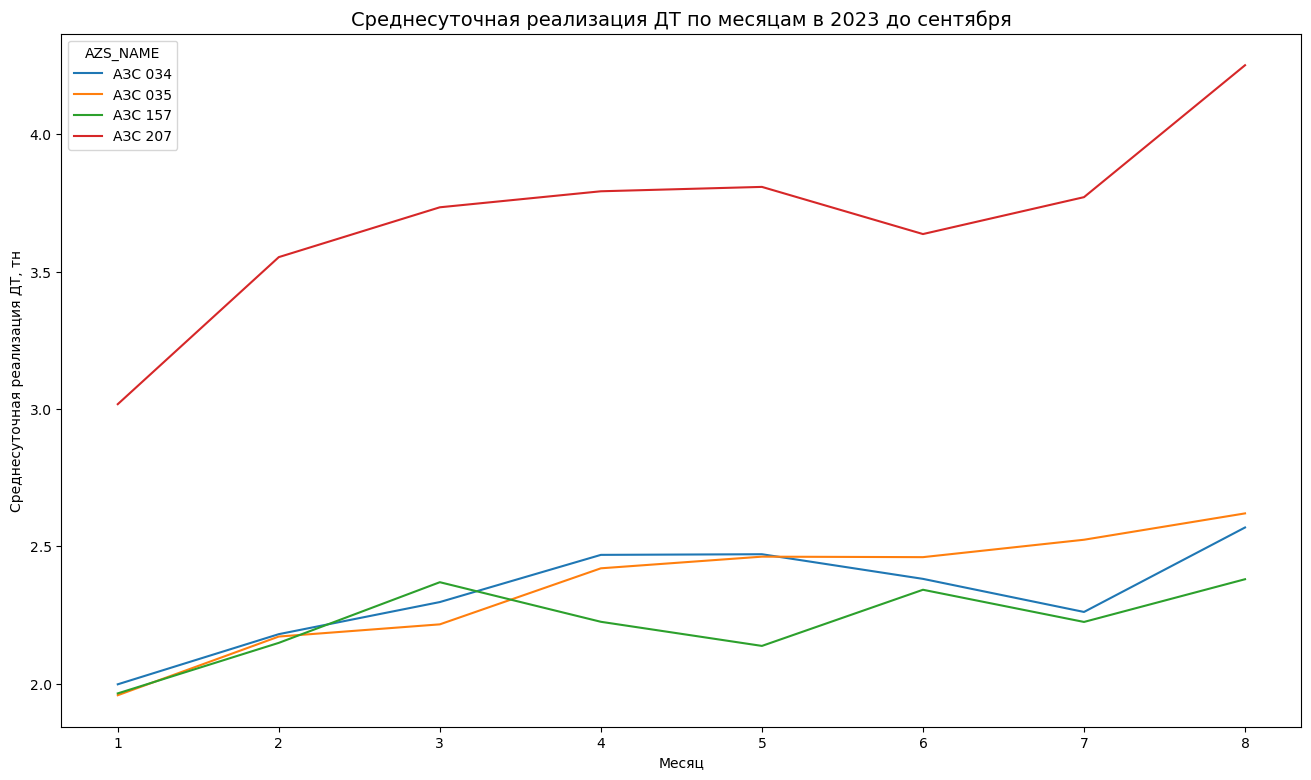

In [522]:
df['month'] = df.FL_EVBDATE.dt.month
t = df \
    .query('FL_EVBDATE < "2023-09-01"') \
    .groupby(['AZS_NAME', 'month'], as_index=False) \
    .agg({'MASSA_TN': 'mean'})

plt.figure(figsize=(16, 9))
sns.lineplot(data=t, x='month', y='MASSA_TN', hue='AZS_NAME')
plt.title('Среднесуточная реализация ДТ по месяцам в 2023 до сентября', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Среднесуточная реализация ДТ, тн')
plt.show();

- Схожие АЗС: 35, 34, 157. 
- АЗС 207 исключаю из анализа

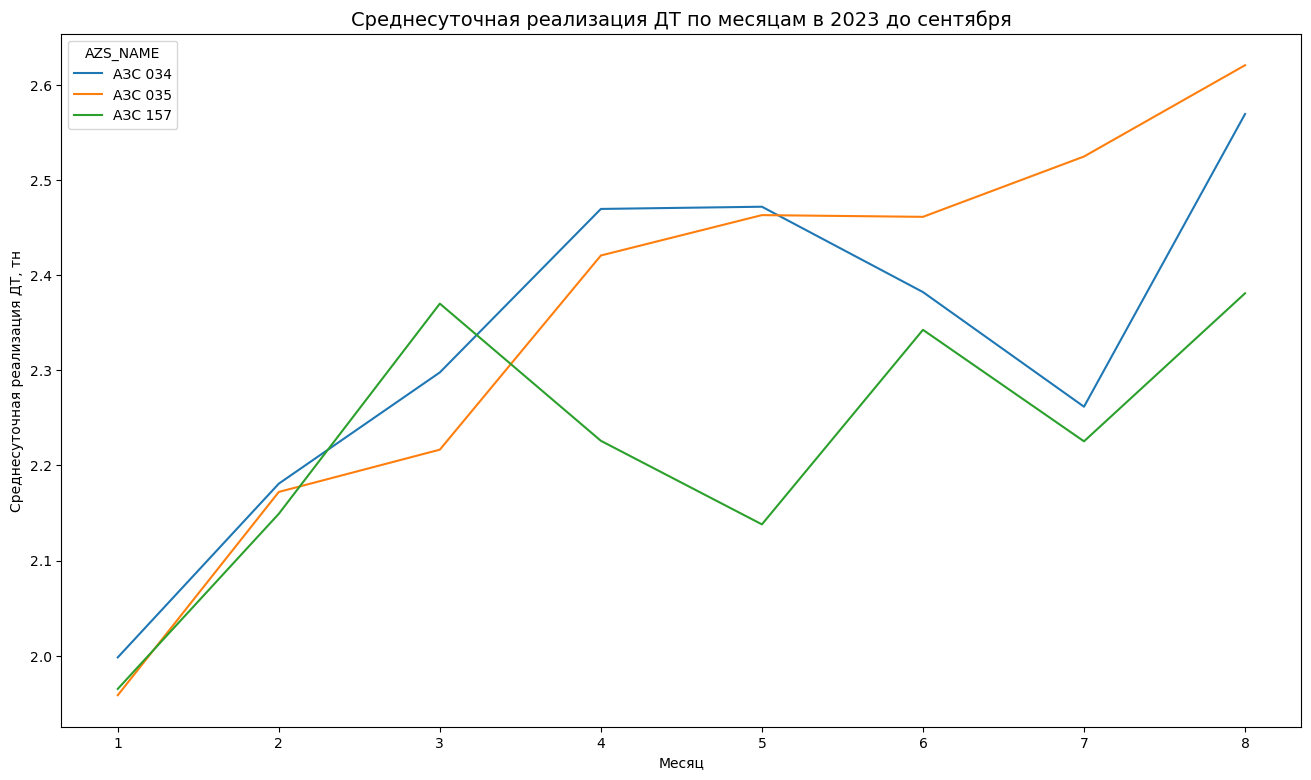

In [523]:
t = df \
    .query('FL_EVBDATE < "2023-09-01" & AZS_NAME != "АЗС 207"') \
    .groupby(['AZS_NAME', 'month'], as_index=False) \
    .agg({'MASSA_TN': 'mean'})

plt.figure(figsize=(16, 9))
sns.lineplot(data=t, x='month', y='MASSA_TN', hue='AZS_NAME')
plt.title('Среднесуточная реализация ДТ по месяцам в 2023 до сентября', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Среднесуточная реализация ДТ, тн')
plt.show();

In [524]:
list_azs = ['АЗС 034', 'АЗС 035', 'АЗС 157']

In [525]:
sample = df \
    .query('FL_EVBDATE < "2023-09-01" & AZS_NAME == @list_azs')
sample.head(2)

,AZS_NAME,FL_EVBDATE,MASSA_TN,month
0,АЗС 034,2023-01-01,0.692400,1
1,АЗС 034,2023-01-02,1.328148,1


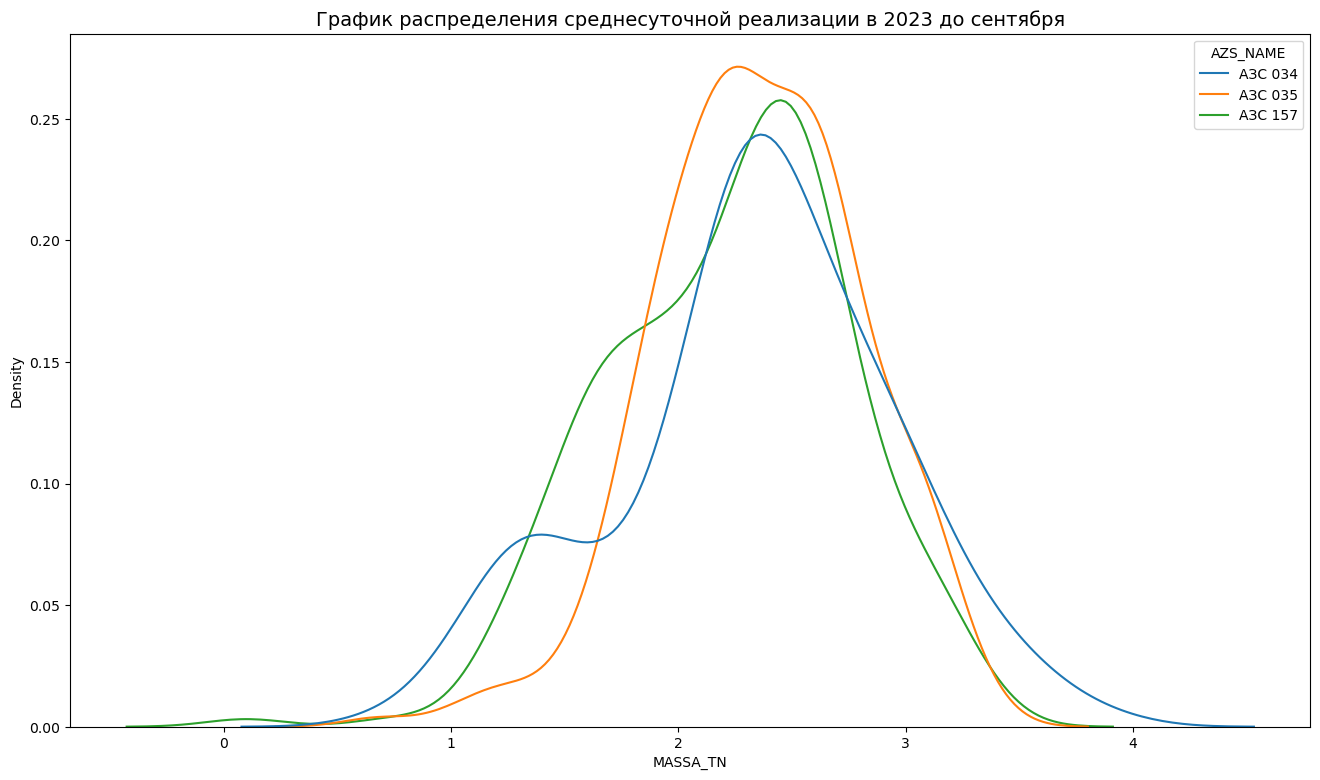

In [526]:
plt.figure(figsize=(16,9))
sns.kdeplot(data=sample, x='MASSA_TN', hue='AZS_NAME')
plt.title('График распределения среднесуточной реализации в 2023 до сентября', fontsize=14)
plt.show();

### Проверка схожести выборок до замены сорта с помощью критерия Колмагорова-Смирнова

H0 - распределения одинаковы  
H1 - распределения различны

In [527]:
# проверка схожести выборок АЗС 035, 034
stat, p_value = kstest(sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN'],
                      sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN'])
if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')

Выборки схожи


In [528]:
# проверка схожести выборок АЗС 035, 157
stat, p_value = kstest(sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN'],
                      sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN'])
if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')

Выборки схожи


Проверка распределний на нормальность

In [529]:
# АЗС 035
if stats.shapiro(sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение не нормальное



In [530]:
# АЗС 034
if stats.shapiro(sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение не нормальное



In [531]:
# АЗС 157
if stats.shapiro(sample.query('AZS_NAME == "АЗС 157"')['MASSA_TN']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное\n')

Распределение не нормальное



* Распределения не нормальные. Для анализа выборок буду применять тест Манн-Уитни

### Сравнение выборок до смены сортности тестом Манн-Уитни    
H0 - нет статистических различий  
H1 - между выборками есть стат.различия

In [533]:
# АЗС 034, АЗС 035
stat, p_value = mannwhitneyu(
    sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN'],
    sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']
)

if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')
    
print(mannwhitneyu(
    sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN'],
    sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']
))

Выборки схожи
MannwhitneyuResult(statistic=29548.0, pvalue=0.9881458126076769)


In [534]:
# АЗС 035, АЗС 157
stat, p_value = mannwhitneyu(
    sample.query('AZS_NAME == "АЗС 157"')['MASSA_TN'],
    sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']
)

if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')
    
print(mannwhitneyu(
    sample.query('AZS_NAME == "АЗС 157"')['MASSA_TN'],
    sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']
))

Выборки различаются
MannwhitneyuResult(statistic=25521.0, pvalue=0.009713561977831582)


In [286]:
# среднесуточная реализация в 2023 до сентября
sample \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'MASSA_TN': 'mean'})

,AZS_NAME,MASSA_TN
0,АЗС 034,2.329959
1,АЗС 035,2.356203
2,АЗС 157,2.225102


**Вывод**: для анализ изменения продаж ДТ буду использовать АЗС 035 и АЗС 034. До смены сортности продажи ДТ были схожи

## Анализ продаж ДТ после смены сортности

In [535]:
list_azs = ['АЗС 034', 'АЗС 035']

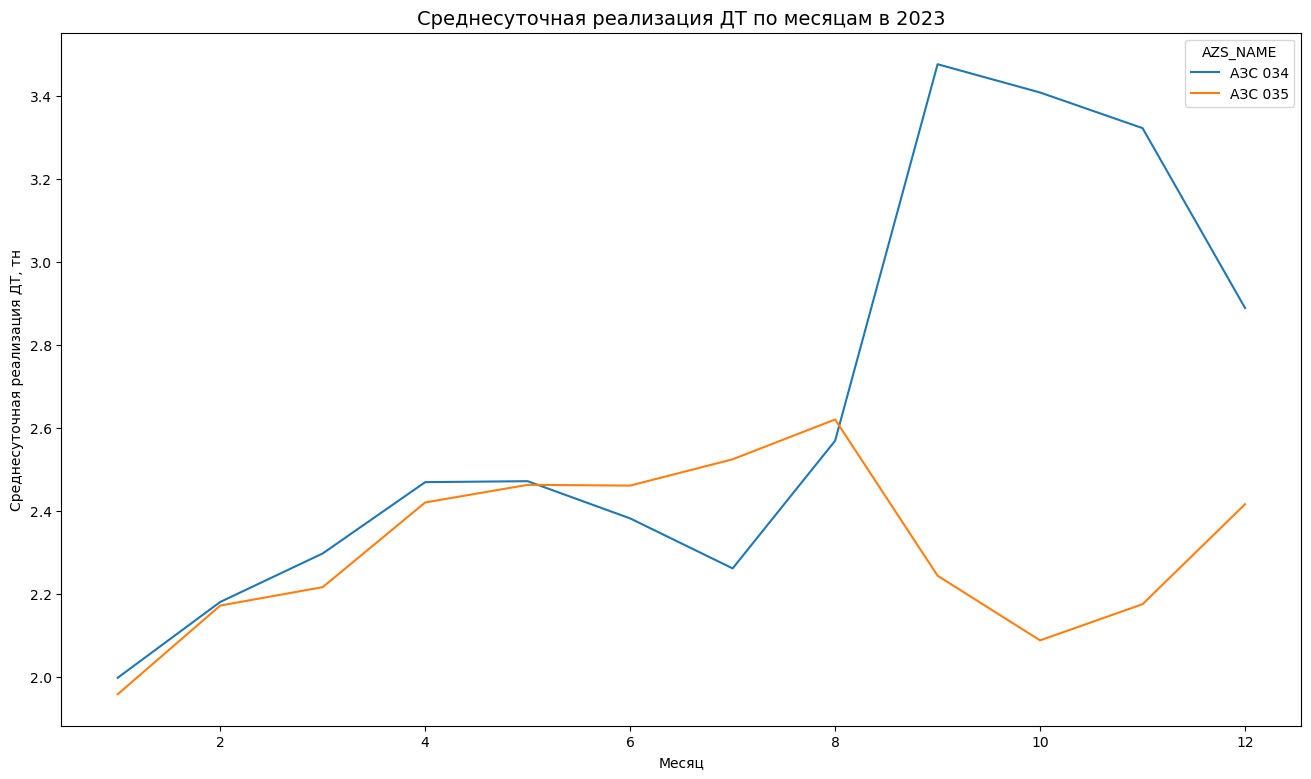

In [536]:
t = df \
    .query('AZS_NAME == @list_azs') \
    .groupby(['AZS_NAME', 'month'], as_index=False) \
    .agg({'MASSA_TN': 'mean'})

plt.figure(figsize=(16, 9))
sns.lineplot(data=t, x='month', y='MASSA_TN', hue='AZS_NAME')
plt.title('Среднесуточная реализация ДТ по месяцам в 2023', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Среднесуточная реализация ДТ, тн')
plt.show();

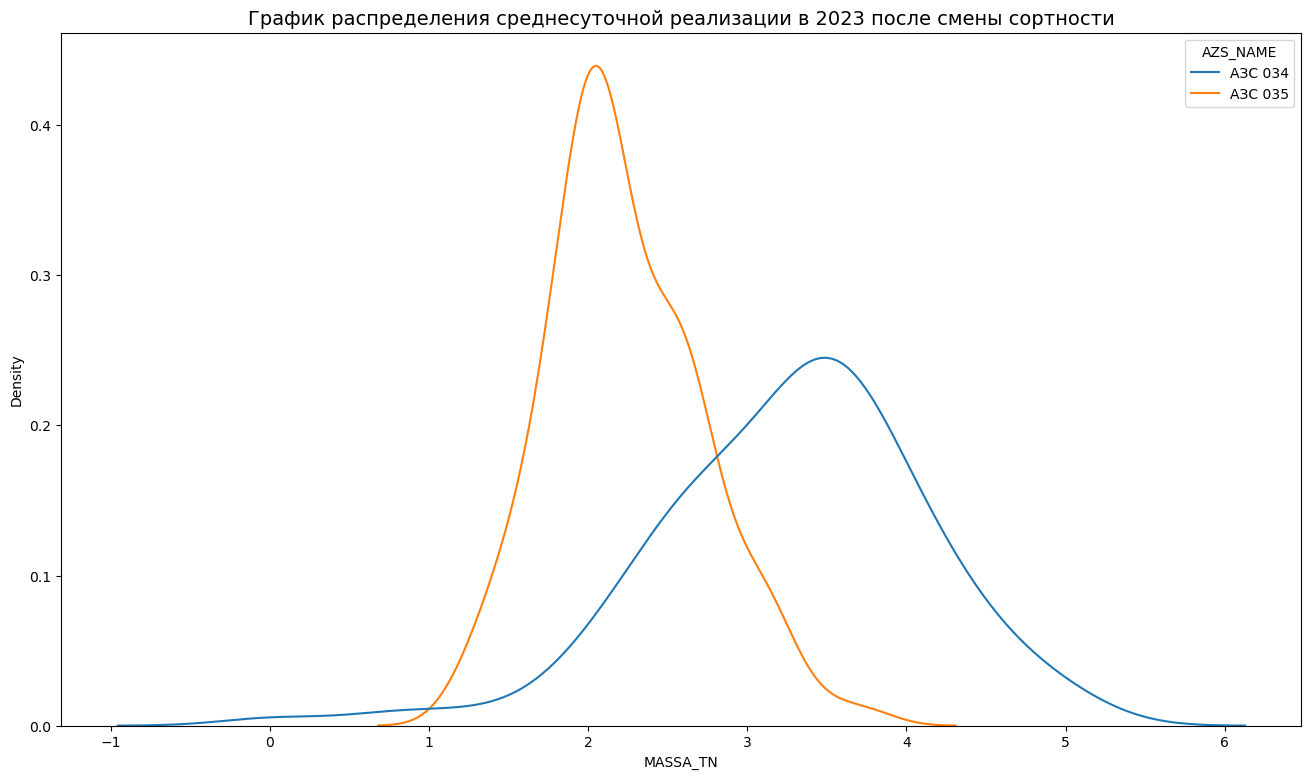

In [537]:
sample = df \
    .query('FL_EVBDATE >= "2023-09-01" & AZS_NAME == @list_azs')

plt.figure(figsize=(16,9))
sns.kdeplot(data=sample, x='MASSA_TN', hue='AZS_NAME')
plt.title('График распределения среднесуточной реализации в 2023 после смены сортности', fontsize=14)
plt.show();

In [538]:
# АЗС 034, АЗС 035
stat, p_value = mannwhitneyu(
    sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN'],
    sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']
)

if p_value < 0.05:
    print('Выборки различаются')
else:
    print('Выборки схожи')
    
print(mannwhitneyu(
    sample.query('AZS_NAME == "АЗС 034"')['MASSA_TN'],
    sample.query('AZS_NAME == "АЗС 035"')['MASSA_TN']
))

Выборки различаются
MannwhitneyuResult(statistic=12919.0, pvalue=2.9432411121238556e-23)


In [539]:
# среднесуточная реализация в 2023 после смены сортности
sample \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'MASSA_TN': 'mean'})

,AZS_NAME,MASSA_TN
0,АЗС 034,3.271832
1,АЗС 035,2.231418


In [540]:
# Ориентировочные потери ДТ после смены сортности (в среднем в сутки)
2.231418-3.271832

-1.0404139999999997

In [541]:
sample \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'MASSA_TN': 'sum'})

,AZS_NAME,MASSA_TN
0,АЗС 034,399.163538
1,АЗС 035,272.233021


In [542]:
# Ориентировочные потери ДТ после смены сортности (с сентября по декабрь)
272.233021-399.163538

-126.93051700000001

**Вывод:**  
После замены ДТ на ДТ Танеко на АЗС 035 произошло падение продаж ДТ в адрес ФЛ. Выявлены стат.значимые различия. Потери составили:    
1. в среднем в стуки 1,05 тн.
2. за 4 месяца 127 тн.

# Гипотеза 2  
Смена сортности позволила больше обслуживать клиентов ФЛ

In [543]:
list_azs = ['АЗС 035', 'АЗС 034']
orders = df_2023 \
    .query('AZS_NAME == @list_azs') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_EVBTIME': 'count'}) \
    .rename(columns={'FL_EVBTIME': 'orders'})
orders.head(2)

,AZS_NAME,FL_EVBDATE,orders
0,АЗС 034,2023-01-01,287
1,АЗС 034,2023-01-02,415


распределение кол-ва транзакций до смены сортности

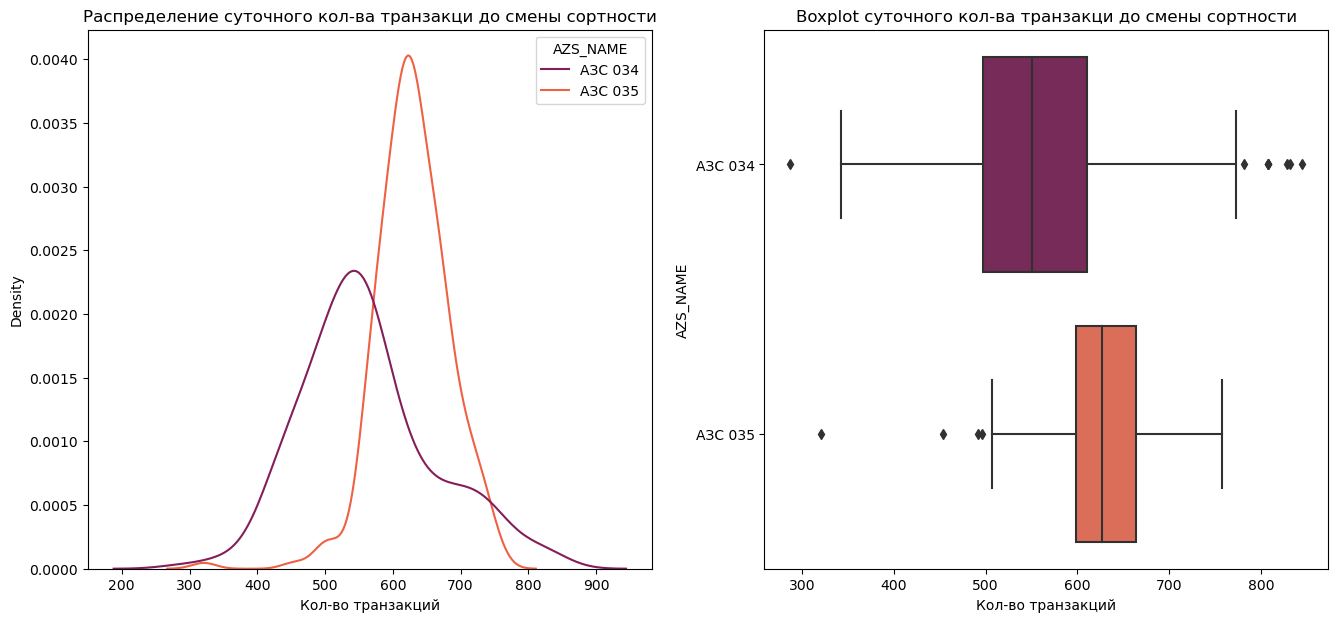

In [544]:
sample = orders \
    .query('FL_EVBDATE < "2023-09-01"')


fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
sns.kdeplot(
    data=sample, x='orders', hue='AZS_NAME',
    palette='rocket',
    ax=axes[0]
)
axes[0].set_title('Распределение суточного кол-ва транзакци до смены сортности')
axes[0].set_xlabel('Кол-во транзакций')

sns.boxplot(
    data=sample, y='AZS_NAME', x='orders', palette='rocket',
    ax=axes[1]
)
axes[1].set_title('Boxplot суточного кол-ва транзакци до смены сортности')
axes[1].set_xlabel('Кол-во транзакций')
plt.show();

In [545]:
sample \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'orders': 'mean'})

,AZS_NAME,orders
0,АЗС 034,561.753086
1,АЗС 035,628.872428


* До смены сортности на АЗС 035 кол-во обслуживаемых клиентов ФЛ было выше чем на АЗС 034

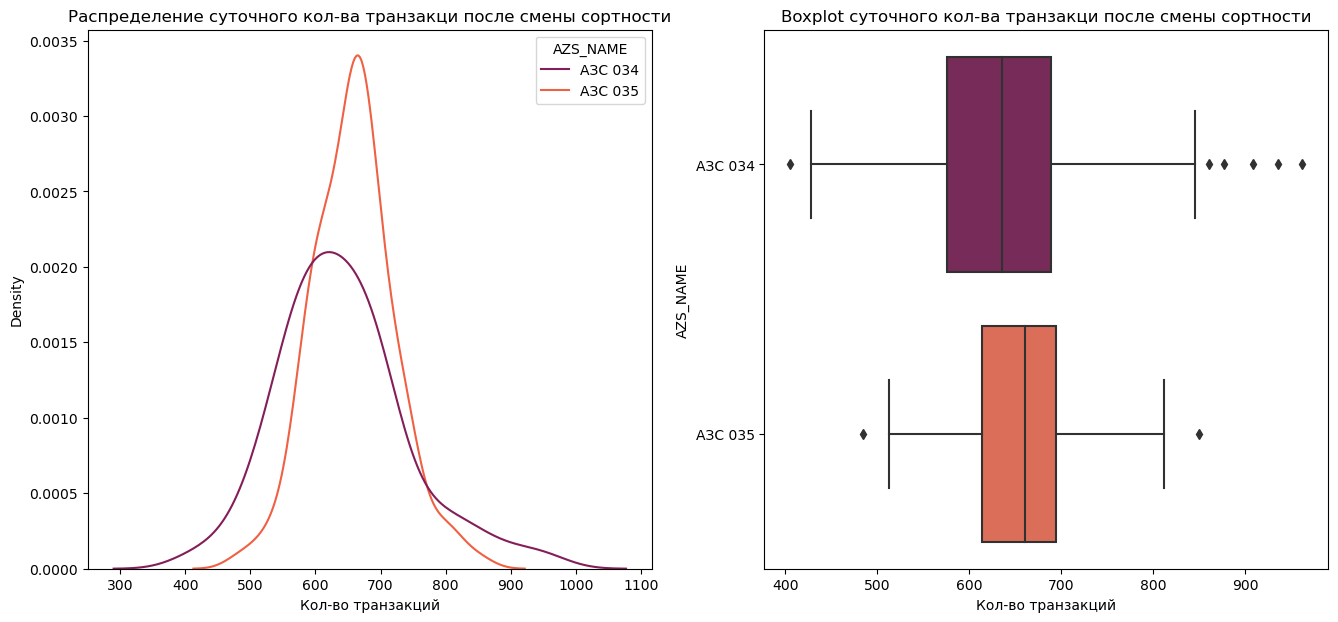

In [546]:
sample = orders \
    .query('FL_EVBDATE > "2023-09-01"')


fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
sns.kdeplot(
    data=sample, x='orders', hue='AZS_NAME',
    palette='rocket',
    ax=axes[0]
)
axes[0].set_title('Распределение суточного кол-ва транзакци после смены сортности')
axes[0].set_xlabel('Кол-во транзакций')

sns.boxplot(
    data=sample, y='AZS_NAME', x='orders', palette='rocket',
    ax=axes[1]
)
axes[1].set_title('Boxplot суточного кол-ва транзакци после смены сортности')
axes[1].set_xlabel('Кол-во транзакций')
plt.show();

In [547]:
sample \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'orders': 'mean'})

,AZS_NAME,orders
0,АЗС 034,641.214876
1,АЗС 035,658.446281


* После смены сортности на АЗС 035 кол-во обслуживаемых клиентов ФЛ осталось также выше чем на АЗС 034, но разница сильно сократилась

In [548]:
orders['period'] = orders.FL_EVBDATE.apply(lambda x: 'период_до_смены_сортности' 
                        if x < pd.to_datetime("2023-09-01", format="%Y-%m-%d") 
                        else 'период после смены сортности')

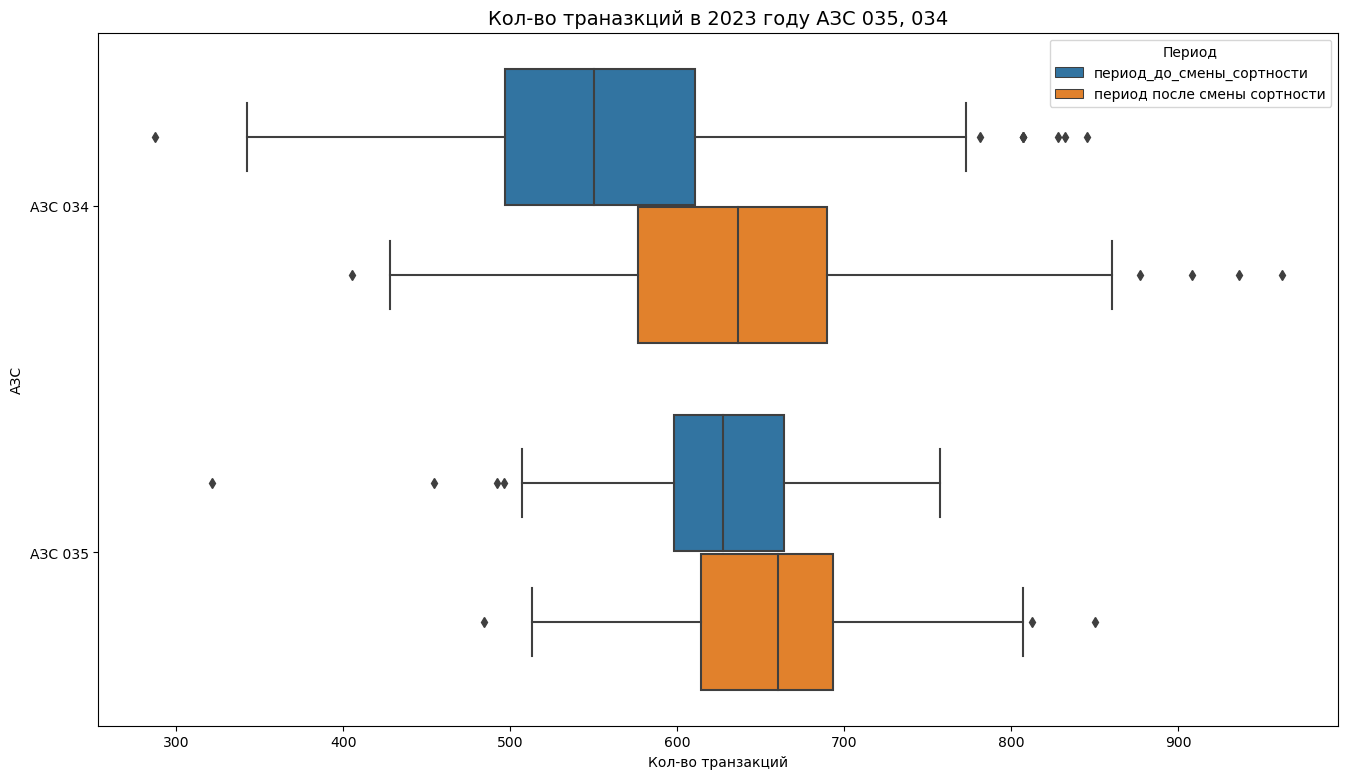

In [549]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=orders, x='orders', y='AZS_NAME', hue='period')
plt.title('Кол-во траназкций в 2023 году АЗС 035, 034', fontsize=14)
plt.xlabel('Кол-во транзакций')
plt.ylabel('АЗС')
plt.legend(title='Период')
plt.show();

* на АЗС 035 незначительно увеличелось среденсуточное кол-во транзакций после смены сортности.  
На АЗС 034 произошёл более сильный рост.

In [550]:
orders_2 = df_2022 \
    .query('AZS_NAME == @list_azs') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_EVBTIME': 'count'}) \
    .rename(columns={'FL_EVBTIME': 'orders'})
orders_2['month'] = orders_2.FL_EVBDATE.dt.month
orders_2.head(2)

,AZS_NAME,FL_EVBDATE,orders,month
0,АЗС 034,2022-01-01,64,1
1,АЗС 034,2022-01-02,507,1


In [554]:
orders['month'] = orders.FL_EVBDATE.dt.month

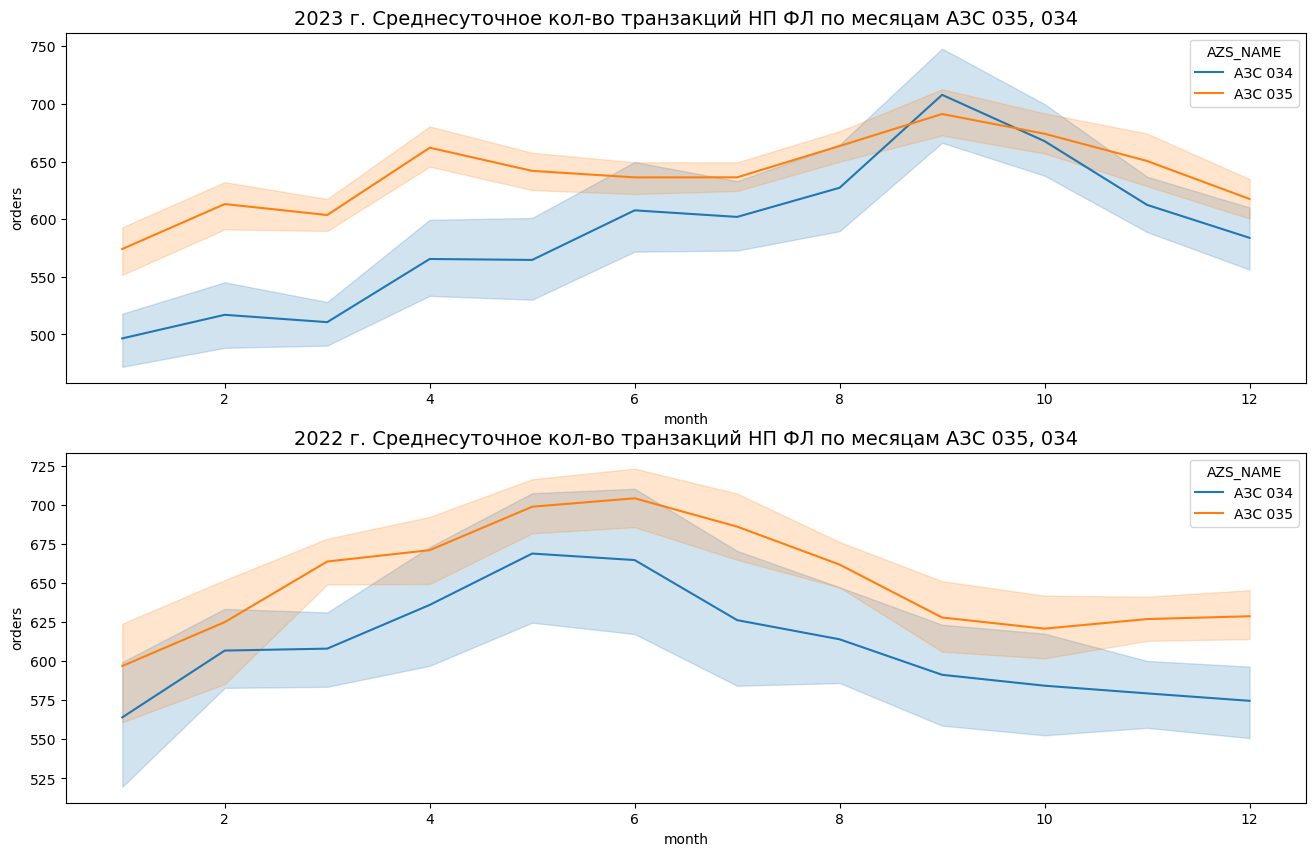

In [555]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 10))
sns.lineplot(data=orders, x='month', y='orders', hue='AZS_NAME',
            ax = axes[0])
axes[0].set_title('2023 г. Среднесуточное кол-во транзакций НП ФЛ по месяцам АЗС 035, 034',
                 fontsize=14)
sns.lineplot(data=orders_2, x='month', y='orders', hue='AZS_NAME',
            ax = axes[1])
axes[1].set_title('2022 г. Среднесуточное кол-во транзакций НП ФЛ по месяцам АЗС 035, 034',
                 fontsize=14)
plt.show();

In [556]:
orders_2['period'] = orders_2.FL_EVBDATE.apply(lambda x: 'период_до_смены_сортности' 
                        if x < pd.to_datetime("2022-09-01", format="%Y-%m-%d") 
                        else 'период после смены сортности')

In [557]:
orders_group = orders \
    .groupby(['AZS_NAME', 'period'], as_index=False) \
    .agg({'orders': 'mean'}) \
    .pivot(index='AZS_NAME', columns='period', values='orders') \
    .reset_index().round(2)

orders_group['dinamics_2023'] = orders_group['период после смены сортности'] / orders_group['период_до_смены_сортности'] - 1
orders_group

period,AZS_NAME,период после смены сортности,период_до_смены_сортности,dinamics_2023
0,АЗС 034,642.66,561.75,0.144032
1,АЗС 035,658.13,628.87,0.046528


In [558]:
orders_group_2 = orders_2 \
    .groupby(['AZS_NAME', 'period'], as_index=False) \
    .agg({'orders': 'mean'}) \
    .pivot(index='AZS_NAME', columns='period', values='orders') \
    .reset_index().round(2)
orders_group_2['dinamics_2022'] = orders_group_2['период после смены сортности'] / orders_group_2['период_до_смены_сортности'] - 1
orders_group[['AZS_NAME', 'dinamics_2023']] \
    .merge(orders_group_2[['AZS_NAME', 'dinamics_2022']], on='AZS_NAME', how='left')

period,AZS_NAME,dinamics_2023,dinamics_2022
0,АЗС 034,0.144032,-0.066155
1,АЗС 035,0.046528,-0.056771


* Вывод:  
В 2023 году после смены сортности на АЗС 035 относительно периода до смены сортности прирост среднесуточного кол-ва транзакций НП в адрес ФЛ составил +4%, а на АЗС 034 (где не было смены сортности) +14%. В 2022 году в аналогичные периоды прирост на обеих АЗС различается на 1%.  
Смена сортности на АЗС 035 не повлияла на увеличение кол-ва обслуживаемых клиентов ФЛ

# Гипотеза 3  
На АЗС 035 после смены сортности выросли продажи НП ФЛ по бензинам

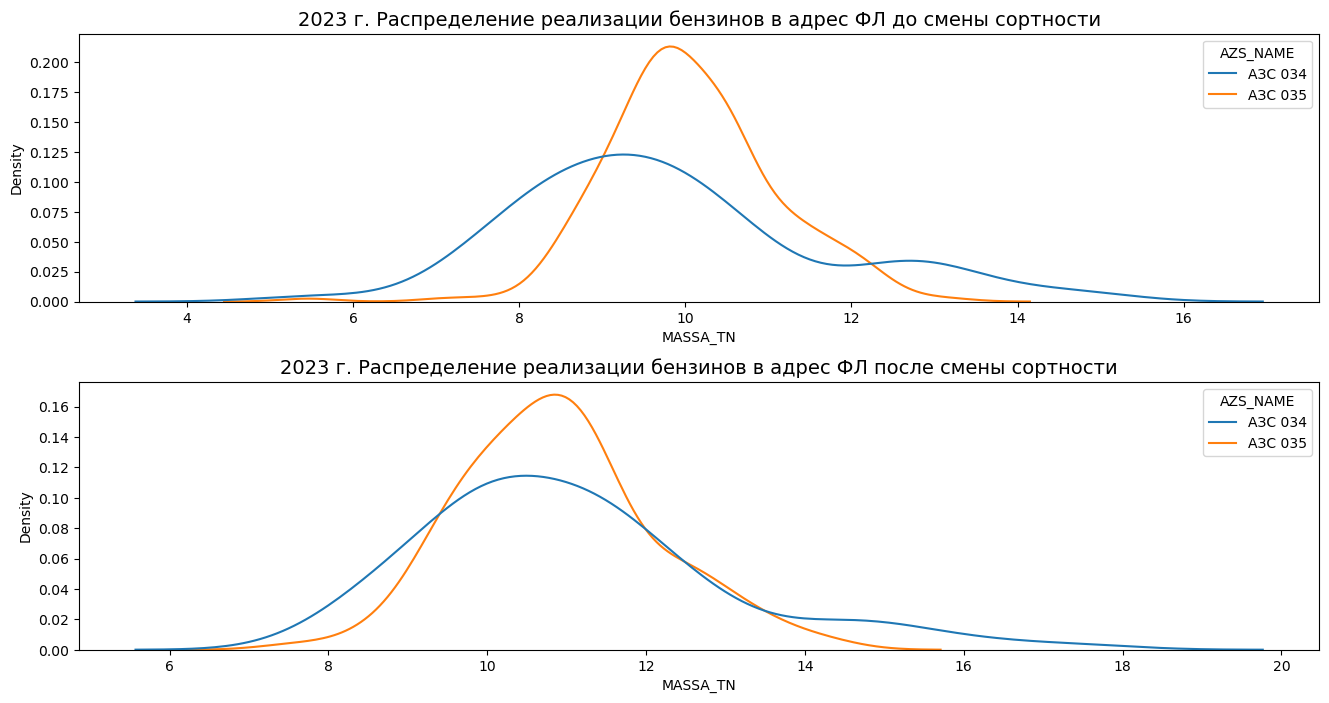

In [561]:
# фильтр продаж в 2023 по бензинам
df = df_2023 \
    .query('AZS_NAME == @list_azs') \
    .query('type_product == "бензин"') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'MASSA_TN': 'sum'})
df['month'] = df.FL_EVBDATE.dt.month

# добавление периодов
df['period'] = df.FL_EVBDATE.apply(lambda x: 'период_до_смены_сортности' 
                        if x < pd.to_datetime("2023-09-01", format="%Y-%m-%d") 
                        else 'период после смены сортности')

# построение графиков распределения
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))
plt.subplots_adjust(hspace=0.3)
sns.kdeplot(data=df.query('period == "период_до_смены_сортности"'), 
            x='MASSA_TN', hue='AZS_NAME', ax = axes[0])
axes[0].set_title('2023 г. Распределение реализации бензинов в адрес ФЛ до смены сортности',
                 fontsize=14)
sns.kdeplot(data=df.query('period == "период после смены сортности"'), 
            x='MASSA_TN', hue='AZS_NAME', ax = axes[1])
axes[1].set_title('2023 г. Распределение реализации бензинов в адрес ФЛ после смены сортности',
                 fontsize=14)
plt.show();

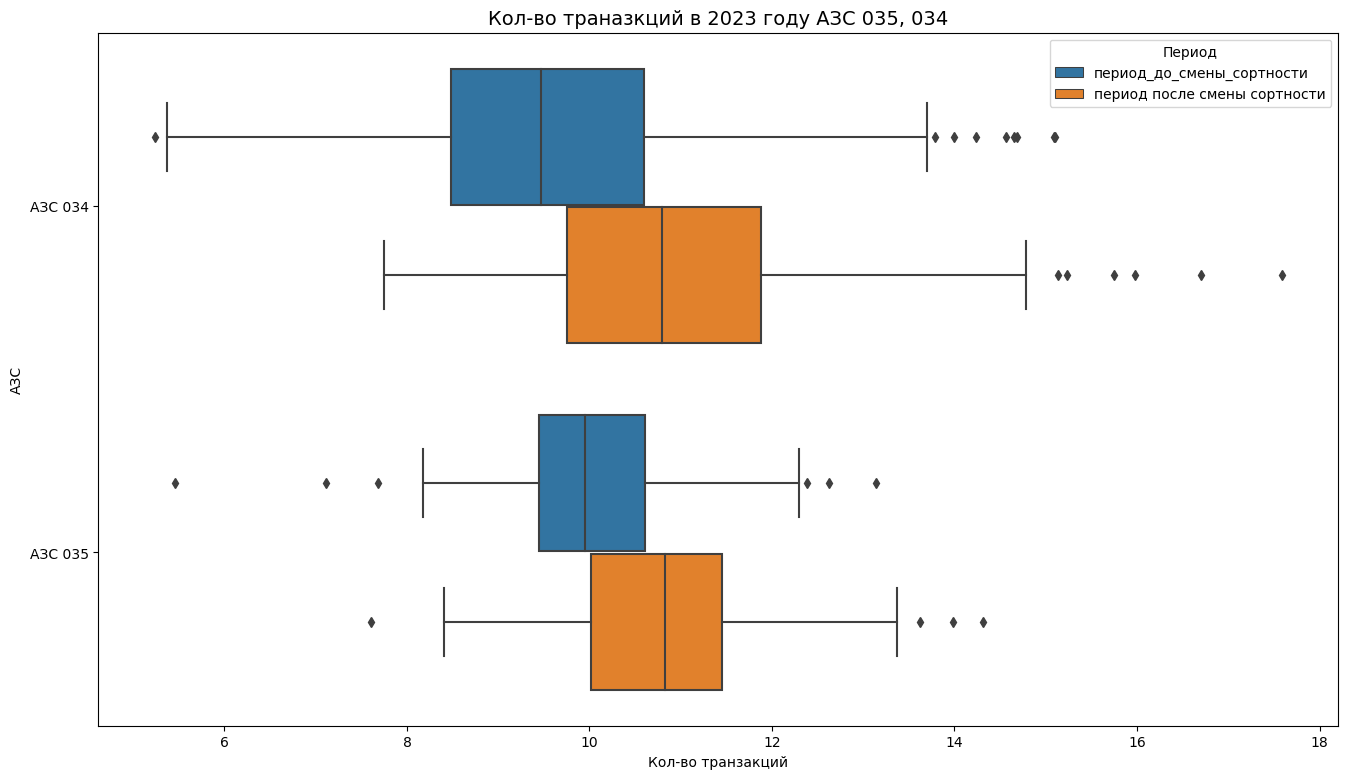

In [562]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=df, x='MASSA_TN', y='AZS_NAME', hue='period')
plt.title('Кол-во траназкций в 2023 году АЗС 035, 034', fontsize=14)
plt.xlabel('Кол-во транзакций')
plt.ylabel('АЗС')
plt.legend(title='Период')
plt.show();

In [563]:
period_1 = df \
    .groupby(['AZS_NAME', 'period'], as_index=False) \
    .agg({'MASSA_TN': 'mean'}) \
    .pivot(index='AZS_NAME', columns='period', values='MASSA_TN') \
    .reset_index()

period_1['dinamics_2023'] = period_1['период после смены сортности'] / period_1['период_до_смены_сортности'] - 1

In [566]:
df_2022['type_product'] = df_2022.PROD_NAME.map(map_product)
# фильтр продаж в 2023 по бензинам
df_2 = df_2022 \
    .query('AZS_NAME == @list_azs') \
    .query('type_product == "бензин"') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'MASSA_TN': 'sum'})

df_2['period'] = df_2.FL_EVBDATE.apply(lambda x: 'период_до_смены_сортности' 
                        if x < pd.to_datetime("2022-09-01", format="%Y-%m-%d") 
                        else 'период после смены сортности')

period_2 = df_2 \
    .groupby(['AZS_NAME', 'period'], as_index=False) \
    .agg({'MASSA_TN': 'mean'}) \
    .pivot(index='AZS_NAME', columns='period', values='MASSA_TN') \
    .reset_index()

period_2['dinamics_2022'] = period_2['период после смены сортности'] / period_2['период_до_смены_сортности'] - 1

In [567]:
period_1[['AZS_NAME', 'dinamics_2023']] \
    .merge(period_2[['AZS_NAME', 'dinamics_2022']], on='AZS_NAME', how='left')

period,AZS_NAME,dinamics_2023,dinamics_2022
0,АЗС 034,0.131059,-0.023033
1,АЗС 035,0.081196,-0.023216


**Вывод:**  
Смена сортности на АЗС 035 не позволила увеличить объём продаж бензинов в адрес ФЛ. В 2022 году динамика на обеих АЗС была примерно схожа, в 2023 году на АЗС 034 (где не было смены сортов) значительно выше приросла среднесуточная реализаци бензинов чем на АЗС 035

# Гипотеза 4  
Произошёл рост конверсии вырчуки от продаж сопутствующих товаров и услуг на литр реализованного топлива в адрес ФЛ

In [568]:
# загрузка данных о продаж сопутствующих товаров и услуг
path = 'D:/QS/2023/rpas/ti/'
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
for x in data:
    month = pd.read_csv(path + x, encoding='cp1251', sep=';', decimal=',', parse_dates=['TIME_KEY', 'TI_EVDATE'], dayfirst=True)
    list_df.append(month)
ti = pd.concat(list_df, axis=0, ignore_index=True)
    
ti['AZS_NAME'] = ti['AZS_NAME'].str.replace('МАЗС', 'АЗС').str.replace('АЗС', 'АЗС ')

In [569]:
ti = ti \
    .query('AZS_NAME == @list_azs') \
    .groupby(['AZS_NAME', 'TI_EVDATE', 'TI_EV_NAME'], as_index=False) \
    .agg({'TI_SUMMA': 'sum'})

In [570]:
ti['TI_SUMMA'] = ti.TI_SUMMA.abs()

In [572]:
ti = ti \
    .pivot(index=['AZS_NAME', 'TI_EVDATE'], columns='TI_EV_NAME', values='TI_SUMMA') \
    .reset_index() \
    .fillna(0)

In [573]:
list(ti.columns)

['AZS_NAME',
 'TI_EVDATE',
 'Смешанный вид продажи',
 'возврат товара                           ',
 'продажа товара                           ']

In [574]:
ti['ti_sales'] = ti['продажа товара                           '] + ti['Смешанный вид продажи'] - ti['возврат товара                           ']

In [575]:
ti = ti.rename(columns={'TI_EVDATE': 'FL_EVBDATE'})

продажи нп

In [576]:
oil = df_2023 \
    .query('AZS_NAME == @list_azs') \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_VOLUME': 'sum'})

In [577]:
# расчёт конверсии: выручка стиу на литр отпущенного топлива
conv = oil \
    .merge(ti[['AZS_NAME', 'FL_EVBDATE', 'ti_sales']], on=['AZS_NAME', 'FL_EVBDATE'], how='left')
conv['conversion'] = conv['ti_sales'] / conv['FL_VOLUME']
conv.head(2)

,AZS_NAME,FL_EVBDATE,FL_VOLUME,ti_sales,conversion
0,АЗС 034,2023-01-01,7944.04,32123.45,4.043717
1,АЗС 034,2023-01-02,11932.69,42208.41,3.537208


In [578]:
conv['period'] = conv.FL_EVBDATE.apply(lambda x: 'период_до_смены_сортности' 
                        if x < pd.to_datetime("2023-09-01", format="%Y-%m-%d") 
                        else 'период_после_смены_сортности')

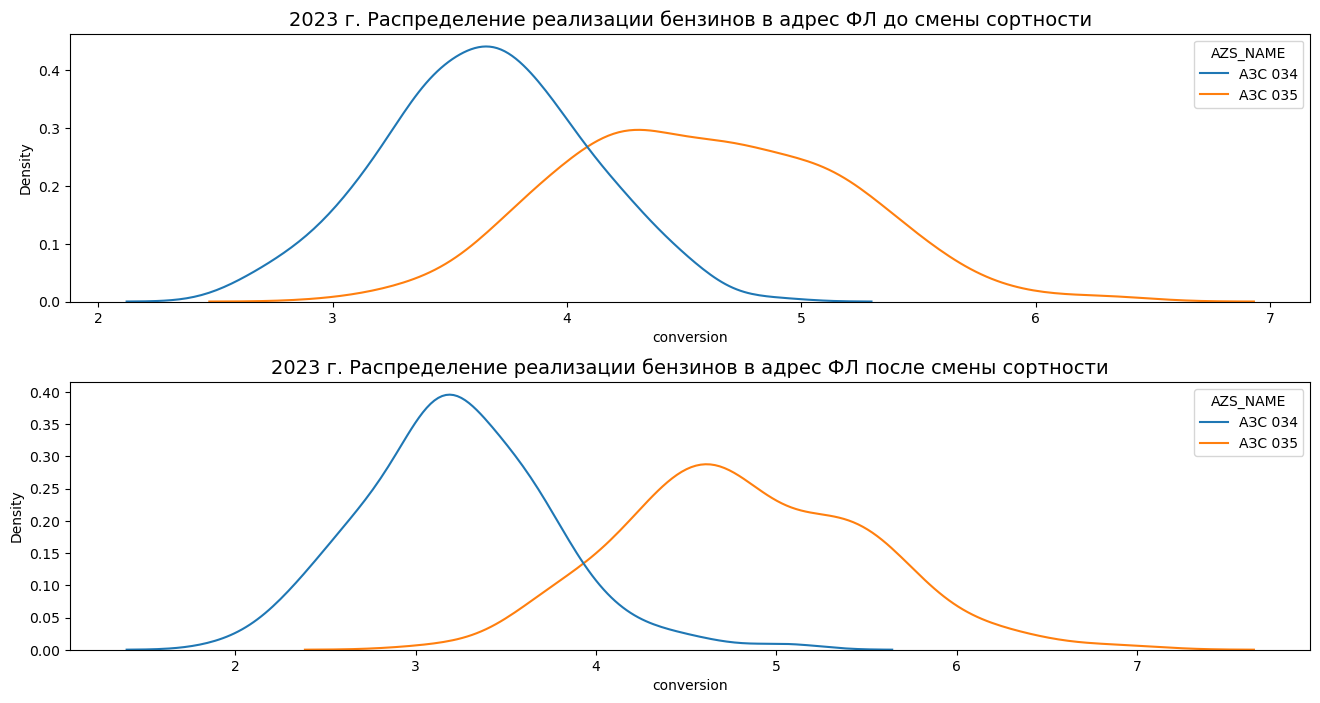

In [579]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))
plt.subplots_adjust(hspace=0.3)
sns.kdeplot(data=conv.query('period == "период_до_смены_сортности"'), 
            x='conversion', hue='AZS_NAME', ax = axes[0])
axes[0].set_title('2023 г. Распределение реализации бензинов в адрес ФЛ до смены сортности',
                 fontsize=14)
sns.kdeplot(data=conv.query('period == "период_после_смены_сортности"'), 
            x='conversion', hue='AZS_NAME', ax = axes[1])
axes[1].set_title('2023 г. Распределение реализации бензинов в адрес ФЛ после смены сортности',
                 fontsize=14)
plt.show();

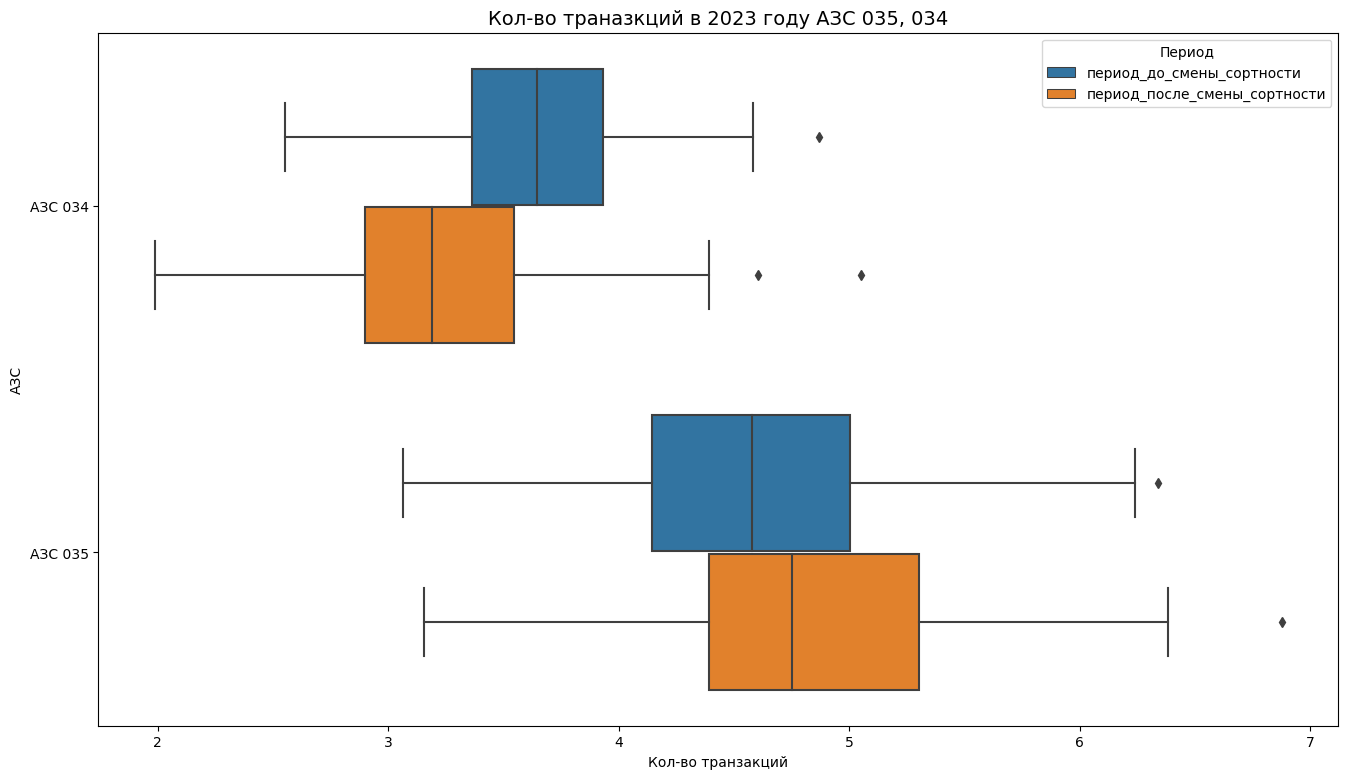

In [580]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=conv, x='conversion', y='AZS_NAME', hue='period')
plt.title('Кол-во траназкций в 2023 году АЗС 035, 034', fontsize=14)
plt.xlabel('Кол-во транзакций')
plt.ylabel('АЗС')
plt.legend(title='Период')
plt.show();

In [581]:
dinamics_conv = conv \
    .groupby(['AZS_NAME', 'period'], as_index=False) \
    .agg({'conversion': 'mean'}) \
    .pivot(index='AZS_NAME', columns='period', values='conversion') \
    .reset_index()

dinamics_conv['dinamics'] = dinamics_conv['период_после_смены_сортности'] / dinamics_conv['период_до_смены_сортности'] - 1
dinamics_conv

period,AZS_NAME,период_до_смены_сортности,период_после_смены_сортности,dinamics
0,АЗС 034,3.644236,3.222812,-0.115641
1,АЗС 035,4.573286,4.826981,0.055473


**Вывод:**  
АЗС 035 после смены сортности показывает положительный прирост конверсии по сравнению с АЗС 034.  
Нельзя однозначно предпологать что это связано со сменой сортности.  
Возможно на рост конверсии сказались иные факторы:  
- текучесть персонала  
- проблемы с поставками товаров стиу или оборудованием на АЗС 034  

Для однозначно вывода по конверсии нужен более детальный анализ продаж СТиУ